In [1]:
##Import packages needed (and some not needed....)

import Bio

import openpyxl
from Bio import SeqIO
import os,sys,re

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import seaborn as sns
print(sns.__name__, sns.__version__)

from collections import Counter
from functools import reduce

import scipy as sp
import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

pandas 1.5.2
numpy 1.23.5
matplotlib 3.4.1
scipy 1.10.0
seaborn 0.12.2


In [2]:
##Write some informations on your assay that we will use later to have titles and save files + load files
name = "Azole specific variants DMS validations"
time = 24 #Needs to be a number, don't add the H after, ex : 24, 32, 36, 48, 72
date = "2023-12-04"

antifungal = "Fluconazole"

OD_file = 'specific_variants_validations_DMS_CB_2023-12-04.xlsx'

select_coef_file = "select_coef_validations_mutants_2023_2023-10-04.xlsx"

#importation of excel plan of the concentrations and the strains in your plate (and the wells)
plan = 'specific_var_val_plan_validations_2023-12-04.xlsx'  ##change the name of the file

concentrations = pd.read_excel(plan, sheet_name='Sheet1', header=0, index_col=0) #sheet 1 = concentrations plan
strains = pd.read_excel(plan, sheet_name='Sheet2', header=0, index_col=0) #sheet 2 = strains plan
well = pd.read_excel(plan, sheet_name='Sheet3', header=0, index_col=0) #sheet 3 = well names plan
antifungals = pd.read_excel(plan, sheet_name='Sheet4', header=0, index_col=0) #sheet 4= antifungals plan


In [3]:
#importation of excel output from the TECAN 
source_df = pd.read_excel(OD_file, header=0, index_col=0)
source_df.head()

,0s,900s,1800s,2700s,3600s,4501s,5401s,6301s,7201s,8101s,...,163822s,164722s,165622s,166522s,167422s,168322s,169222s,170122s,171022s,171923s
A1,0.11758,0.11735,0.11735,0.11745,0.11748,0.11765,0.11740,0.11760,0.11763,0.11770,...,0.74300,0.74195,0.74168,0.74298,0.74213,0.74233,0.74205,0.74240,0.74202,0.74195
B1,0.12248,0.12150,0.12153,0.12127,0.12050,0.12045,0.12108,0.12078,0.12085,0.12113,...,0.50790,0.50865,0.50928,0.51022,0.50970,0.51060,0.51085,0.51170,0.51140,0.51243
C1,0.11713,0.11677,0.11668,0.11635,0.11623,0.11623,0.11625,0.11640,0.11645,0.11655,...,0.61030,0.61250,0.61143,0.61217,0.61220,0.61260,0.61267,0.61333,0.61225,0.61163
D1,0.11780,0.11825,0.11780,0.11762,0.11752,0.11743,0.11745,0.11760,0.11753,0.11775,...,0.15768,0.15890,0.16010,0.16095,0.16143,0.16200,0.16272,0.16373,0.16453,0.16578
E1,0.11668,0.11703,0.11670,0.11677,0.11662,0.11650,0.11655,0.11663,0.11687,0.11685,...,0.45788,0.46103,0.46455,0.46685,0.46883,0.47148,0.47335,0.47552,0.47715,0.47900


In [4]:
#conversion of timepoints (s) -> (h)
rename_dict = {}

for col_name in source_df.columns:
    to_hours = np.float64(col_name.strip('s'))/(60*60)
    rename_dict[col_name] = to_hours
    
source_df.rename(columns = rename_dict, inplace=True)

source_df.head()

,0.000000,0.250000,0.500000,0.750000,1.000000,1.250278,1.500278,1.750278,2.000278,2.250278,...,45.506111,45.756111,46.006111,46.256111,46.506111,46.756111,47.006111,47.256111,47.506111,47.756389
A1,0.11758,0.11735,0.11735,0.11745,0.11748,0.11765,0.11740,0.11760,0.11763,0.11770,...,0.74300,0.74195,0.74168,0.74298,0.74213,0.74233,0.74205,0.74240,0.74202,0.74195
B1,0.12248,0.12150,0.12153,0.12127,0.12050,0.12045,0.12108,0.12078,0.12085,0.12113,...,0.50790,0.50865,0.50928,0.51022,0.50970,0.51060,0.51085,0.51170,0.51140,0.51243
C1,0.11713,0.11677,0.11668,0.11635,0.11623,0.11623,0.11625,0.11640,0.11645,0.11655,...,0.61030,0.61250,0.61143,0.61217,0.61220,0.61260,0.61267,0.61333,0.61225,0.61163
D1,0.11780,0.11825,0.11780,0.11762,0.11752,0.11743,0.11745,0.11760,0.11753,0.11775,...,0.15768,0.15890,0.16010,0.16095,0.16143,0.16200,0.16272,0.16373,0.16453,0.16578
E1,0.11668,0.11703,0.11670,0.11677,0.11662,0.11650,0.11655,0.11663,0.11687,0.11685,...,0.45788,0.46103,0.46455,0.46685,0.46883,0.47148,0.47335,0.47552,0.47715,0.47900


In [5]:
##changing this large dataframe in a super long one
longdf = source_df.reset_index().rename(columns = {'index' : 'well'})
longdf = longdf.melt(id_vars = ['well'], var_name = 'time (h)', value_name = 'OD')
longdf

,well,time (h),OD
0,A1,0.0,0.11758
1,B1,0.0,0.12248
2,C1,0.0,0.11713
3,D1,0.0,0.11780
4,E1,0.0,0.11668
...,...,...,...
36859,L12,47.756389,0.54083
36860,M12,47.756389,0.55567
36861,N12,47.756389,0.62908
36862,O12,47.756389,0.73070


In [6]:
#Merge all the plans to get a big dataframe 
df=pd.DataFrame({'strains':strains.values.ravel(), 'concentrations':concentrations.values.ravel(),'well':well.values.ravel(),'antifungals':antifungals.values.ravel()})
df = df.dropna() ##drop all the rows with NaN values (ex: empty wells in your plates)

df = df.sort_values(['concentrations',"strains","antifungals"])
df

,strains,concentrations,well,antifungals
84,Empty,0.0,H1,Control
85,Empty,0.0,H2,Control
86,Empty,0.0,H3,Control
87,Empty,0.0,H4,Control
88,Empty,0.0,H5,Control
...,...,...,...,...
105,Y132M,10.5,I10,Fluconazole
4,Y132N,10.5,A5,Fluconazole
5,Y132N,10.5,A6,Fluconazole
100,Y132N,10.5,I5,Fluconazole


In [7]:
#Get a list of your strains from the dataframe
strains = df["strains"].tolist()
strains = list(dict.fromkeys(strains)) ##keeps only the unique values to not have the same strain 324712983 times in the list
strains

['Empty', 'I379K', 'K143L', 'V112K', 'WT', 'Y132M', 'Y132N', 'blank']

In [8]:
#Get a list of your concentrations from the dataframe
concentrations = df["concentrations"].tolist()
concentrations = list(dict.fromkeys(concentrations)) ##keeps only the unique values to not have the same strain 324712983 times in the list
concentrations

[0.0, 0.08, 0.1, 0.15, 0.25, 0.3, 10.5]

In [9]:
##Link the tecan output to the plans based on the wells
merged_df = longdf.merge(right=df, on=['well'])
merged_df

,well,time (h),OD,strains,concentrations,antifungals
0,A1,0.0,0.11758,K143L,10.5,Fluconazole
1,A1,0.25,0.11735,K143L,10.5,Fluconazole
2,A1,0.5,0.11735,K143L,10.5,Fluconazole
3,A1,0.75,0.11745,K143L,10.5,Fluconazole
4,A1,1.0,0.11748,K143L,10.5,Fluconazole
...,...,...,...,...,...,...
36859,P12,46.756111,0.11230,blank,0.0,Control
36860,P12,47.006111,0.11175,blank,0.0,Control
36861,P12,47.256111,0.11160,blank,0.0,Control
36862,P12,47.506111,0.11150,blank,0.0,Control


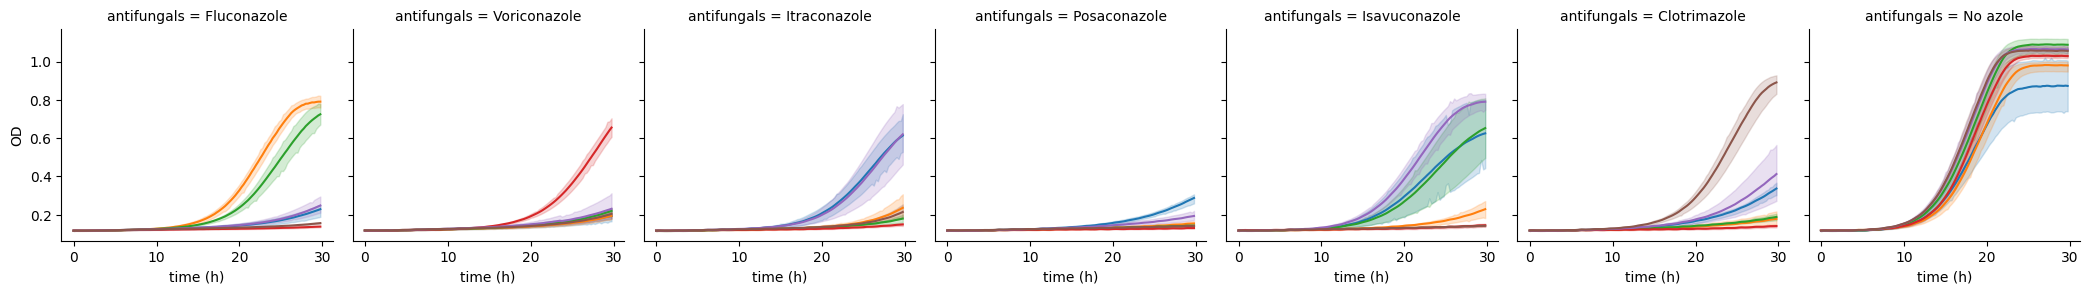

In [21]:
##Growth curves visualisation, the columns will be the different strains and the colors the different concentrations
##It can take between 30 secondes to 5 minutes to load as there is a lot of data

grid = sns.FacetGrid(data=merged_df[merged_df['time (h)'] <= 30], col = "antifungals",  
                     col_order = ["Fluconazole","Voriconazole","Itraconazole","Posaconazole","Isavuconazole","Clotrimazole","No azole"]
                     , hue_order = ['WT','K143L', 'I379K', 'Y132N',  'V112K',  'Y132M'],hue="strains" )
#to see only one add col_order=["name"] in sns.FacetGrid
grid.map(sns.lineplot, 'time (h)', 'OD')
grid.set_axis_labels('time (h)', 'OD')
#grid.add_legend(title = (name + ' Concentrations (ug/mL)'))
grid.fig.subplots_adjust(top=0.9)

axes = grid.axes.flatten()

name1 = "GrowthCurves_" + name + str(time) + "H_" + date  
plt.savefig(f"c:{name1}.png", format='png', dpi=300)

In [11]:
#Definition of the area under the curve (AUC) calculation, the calculation is made from the ODs
def get_auc(g):
    return np.trapz(g.OD)

In [12]:
##Add the AUC on the Df without ODs to limit the quatity of data we continue with
aucdf = merged_df[merged_df['time (h)'] <= 24].groupby('well')[['OD']].apply(func=get_auc).reset_index(name='auc24')
condensed_df = df.merge(right=aucdf, on=['well'])

aucdf = merged_df[merged_df['time (h)'] <= 30].groupby('well')[['OD']].apply(func=get_auc).reset_index(name='auc30')
condensed_df = condensed_df.merge(right=aucdf, on=['well'])
aucdf = merged_df[merged_df['time (h)'] <= 48].groupby('well')[['OD']].apply(func=get_auc).reset_index(name='auc48')
condensed_df = condensed_df.merge(right=aucdf, on=['well'])
condensed_df.head()

,strains,concentrations,well,antifungals,auc24,auc30,auc48
0,Empty,0.0,H1,Control,11.356550,14.266575,23.017145
1,Empty,0.0,H2,Control,11.442020,14.394205,23.309640
2,Empty,0.0,H3,Control,10.736715,13.457710,21.638730
3,Empty,0.0,H4,Control,11.533965,14.500515,23.480945
4,Empty,0.0,H5,Control,11.362155,14.297245,23.192895


In [14]:
# Filter rows where 'strains' is equal to 'blank' and calculate the mean of 'auc'
med_auc_blank = condensed_df[condensed_df['strains'] == 'blank']['auc30'].median()

print("Median AUC for 'blank':", med_auc_blank)

# Subtract the mean AUC of 'blank' from all 'auc' values
condensed_df['auc30_noblank'] = condensed_df['auc30'] - med_auc_blank



Median AUC for 'blank': 13.434480000000002


In [15]:
condensed_df

,strains,concentrations,well,antifungals,auc24,auc30,auc48,auc30_noblank
0,Empty,0.0,H1,Control,11.356550,14.266575,23.017145,0.832095
1,Empty,0.0,H2,Control,11.442020,14.394205,23.309640,0.959725
2,Empty,0.0,H3,Control,10.736715,13.457710,21.638730,0.023230
3,Empty,0.0,H4,Control,11.533965,14.500515,23.480945,1.066035
4,Empty,0.0,H5,Control,11.362155,14.297245,23.192895,0.862765
...,...,...,...,...,...,...,...,...
187,Y132M,10.5,I10,Fluconazole,11.962410,15.557880,36.497420,2.123400
188,Y132N,10.5,A5,Fluconazole,11.667855,14.921560,29.175120,1.487080
189,Y132N,10.5,A6,Fluconazole,11.763285,15.006620,28.972650,1.572140
190,Y132N,10.5,I5,Fluconazole,11.805385,15.041685,28.383455,1.607205


In [16]:
condensed_df["auc30_noblank_log2"] = np.log2(condensed_df["auc30_noblank"])

#condensed_df['auc30_noblank_log2_norm'] = condensed_df['auc30_noblank_log2'] / condensed_df.loc[condensed_df['strains'] == 'WT', 'auc30_noblank_log2'].mean()

C:\Users\CABED117\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
# Custom function to perform division by mean of "WT" strain
def divide_by_wt_mean(group):
    wt_mean_auc = group[group['strains'] == 'WT']['auc30_noblank_log2'].mean()
    group['auc30_noblank_log2_normalized'] = group['auc30_noblank_log2'] / wt_mean_auc
    return group

# Applying the custom function using groupby
result_df = condensed_df.groupby('antifungals').apply(divide_by_wt_mean)

# Displaying the result
result_df

C:\Users\CABED117\AppData\Local\Temp\ipykernel_19564\312453008.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  result_df = condensed_df.groupby('antifungals').apply(divide_by_wt_mean)


,strains,concentrations,well,antifungals,auc24,auc30,auc48,auc30_noblank,auc30_noblank_log2,auc30_noblank_log2_normalized
0,Empty,0.0,H1,Control,11.356550,14.266575,23.017145,0.832095,-0.265180,NaN
1,Empty,0.0,H2,Control,11.442020,14.394205,23.309640,0.959725,-0.059307,NaN
2,Empty,0.0,H3,Control,10.736715,13.457710,21.638730,0.023230,-5.427867,NaN
3,Empty,0.0,H4,Control,11.533965,14.500515,23.480945,1.066035,0.092255,NaN
4,Empty,0.0,H5,Control,11.362155,14.297245,23.192895,0.862765,-0.212960,NaN
...,...,...,...,...,...,...,...,...,...,...
187,Y132M,10.5,I10,Fluconazole,11.962410,15.557880,36.497420,2.123400,1.086376,0.629392
188,Y132N,10.5,A5,Fluconazole,11.667855,14.921560,29.175120,1.487080,0.572482,0.331667
189,Y132N,10.5,A6,Fluconazole,11.763285,15.006620,28.972650,1.572140,0.652730,0.378159
190,Y132N,10.5,I5,Fluconazole,11.805385,15.041685,28.383455,1.607205,0.684554,0.396596


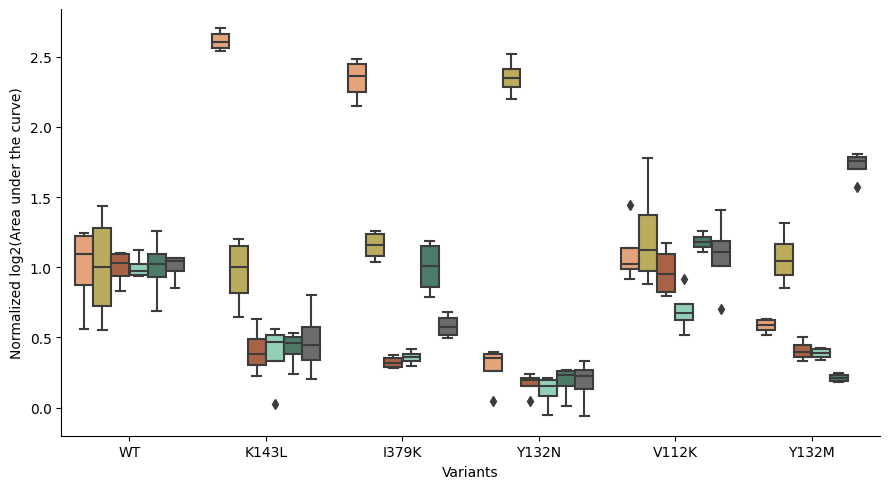

In [19]:
# Create the AUC boxplot
custom_palette = sns.blend_palette(["#F59F6A","#CAB54D","#B85B36","#86DAB9","#44836A","#6C6C6C"],n_colors=6)
order = ['WT','K143L', 'I379K', 'Y132N',  'V112K',  'Y132M']

col_order = ["Fluconazole","Voriconazole","Itraconazole","Posaconazole","Isavuconazole","Clotrimazole"]

box = sns.catplot(x="strains", y="auc30_noblank_log2_normalized", hue="antifungals", hue_order=col_order,data=result_df, order=order, kind="box", 
                  height=5, aspect=1.8, dodge=True,palette=custom_palette, legend=False) 

box.set_axis_labels('Variants', 'Normalized log2(Area under the curve)')

#plt.title("Area under the curve in the presence of Fluconazole",size=18)
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure
name1 = "Boxplot_AUC30_" + name + str(time) + "H_" + date
plt.savefig(f"c:{name1}.png", format='png', dpi=300)
plt.savefig(f"c:{name1}.svg", format='svg', transparent=True, dpi=300)
plt.show()

In [20]:
from scipy.stats import mannwhitneyu
result_df = result_df[result_df['antifungals'] != 'Control']
# Assuming your DataFrame is named concat_df_r

# List of antifungals
antifungals = result_df['antifungals'].unique()

# List of selected variants
variants = ['WT','K143L', 'I379K', 'Y132N',  'V112K',  'Y132M']

# Iterate over antifungals
for antifungal in antifungals:
    # Select data for the current antifungal
    antifungal_data = result_df[result_df['antifungals'] == antifungal]
    
    # Select data for the WT strain
    wt_data = antifungal_data[antifungal_data['strains'] == 'WT']
    
    # Iterate over selected variants and perform Mann-Whitney U test
    for variant in variants:
        if variant != 'WT':
            variant_data = antifungal_data[antifungal_data['strains'] == variant]
            
            # Perform Mann-Whitney U test
            statistic, p_value = mannwhitneyu(
                wt_data['auc30_noblank_log2_normalized'].dropna(),
                variant_data['auc30_noblank_log2_normalized'].dropna()
            )
            
            # Print or store the results
            print(f"Mann-Whitney U test for {variant} against WT for {antifungal}:")
            print(f"U statistic: {statistic}, p-value: {p_value}")
            print("\n")

Mann-Whitney U test for K143L against WT for No azole:
U statistic: 8.0, p-value: 1.0


Mann-Whitney U test for I379K against WT for No azole:
U statistic: 2.0, p-value: 0.11428571428571428


Mann-Whitney U test for Y132N against WT for No azole:
U statistic: 2.0, p-value: 0.11428571428571428


Mann-Whitney U test for V112K against WT for No azole:
U statistic: 0.0, p-value: 0.02857142857142857


Mann-Whitney U test for Y132M against WT for No azole:
U statistic: 0.0, p-value: 0.02857142857142857


Mann-Whitney U test for K143L against WT for Voriconazole:
U statistic: 9.0, p-value: 0.8857142857142857


Mann-Whitney U test for I379K against WT for Voriconazole:
U statistic: 7.0, p-value: 0.8857142857142857


Mann-Whitney U test for Y132N against WT for Voriconazole:
U statistic: 0.0, p-value: 0.02857142857142857


Mann-Whitney U test for V112K against WT for Voriconazole:
U statistic: 5.0, p-value: 0.4857142857142857


Mann-Whitney U test for Y132M against WT for Voriconazole:
U statis